In [1]:
import pandas as pd
import pickle
import torch
from torch_geometric.data import Data, Dataset

As a sort of test to get aquainted with GNN's lets first try to use them for node level predictions by predicting the sex and native language of meeting participants. We will start with sex, although I would be surprised if any notable differences actually exist. 

In [64]:
participant_info = pd.read_csv('/Users/manuelnunezmartinez/Documents/UF/Research Internship/code/corpusResources/summary.csv')
# Extract sex from the ID column
participant_info['Sex'] = participant_info['ID'].apply(lambda x: 'F' if x[0] == 'F' else 'M')
participant_info.head()


,Unnamed: 0,ID,Native Language,Months Learning,Influences,Meeting,Letter,Role,Sex
0,0,FEE005,English,NaN,NaN,ES2002a,B,PM,F
1,1,FEE005,English,NaN,NaN,ES2002b,B,PM,F
2,2,FEE005,English,NaN,NaN,ES2002c,B,PM,F
3,3,FEE005,English,NaN,NaN,ES2002d,B,PM,F
4,4,MEE006,English,NaN,"['Mandarin', 'Cantonese']",ES2002a,A,ID,M


In [65]:
participant_info = participant_info.dropna(subset=['Native Language'])
participant_info.info()

<class 'pandas.core.frame.DataFrame'>
Index: 518 entries, 0 to 521
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       518 non-null    int64  
 1   ID               518 non-null    object 
 2   Native Language  518 non-null    object 
 3   Months Learning  118 non-null    float64
 4   Influences       287 non-null    object 
 5   Meeting          518 non-null    object 
 6   Letter           518 non-null    object 
 7   Role             392 non-null    object 
 8   Sex              518 non-null    object 
dtypes: float64(1), int64(1), object(7)
memory usage: 40.5+ KB


In [80]:
# Count the occurrences of "English"
english_count = participant_info[participant_info['Native Language'] == 'English'].shape[0]

# Count the occurrences of non-English languages
non_english_count = participant_info[participant_info['Native Language'] != 'English'].shape[0]

# Output the counts
print(f"Number of English native speakers: {english_count}")
print(f"Number of non-English native speakers: {non_english_count}")

Number of English native speakers: 305
Number of non-English native speakers: 213


Below we implenent the model necessary for all models built using Pytorch. This dataset must, at the bare minimum overload the following methods: 
- An Initialization method, which in this case uses a list of meetings and their respective interaction features together with a list of the sex for each participant in each meeting, to compose an "X and Y" such that each partiticpants sex is linked to their interactive behavior 
- A length method to 
- A method to obtain an entry gievn an index. Note that this requires the dataset to be oridnal such that each X is matched to its respective Y. 

Below we implement the dataset necessary for all models build using 

In [81]:
from torch.utils.data import Dataset
from torch_geometric.data import Data

class MyGraphDataset(Dataset):
    def __init__(self, data_list, participant_info):
        super(MyGraphDataset, self).__init__()
        self.participant_info = participant_info

        # Filter the data_list to only include entries with valid participants
        self.data_list = []
        for entry in data_list:
            meeting, start_time, (node_dic, edge_dic) = entry
            valid = True
            for node in node_dic.keys():
                participant_id = self.participant_info[(self.participant_info['Meeting'] == meeting) & (self.participant_info['Letter'] == node)]['ID']
                if participant_id.empty:
                    valid = False
                    break
            if valid:
                # Add node info
                node_label = {}
                for node in node_dic.keys():
                    participant_id = self.participant_info[(self.participant_info['Meeting'] == meeting) & (self.participant_info['Letter'] == node)]['ID'].values[0]
                    label = self.participant_info[self.participant_info['ID'] == participant_id]['Native Language'].values[0]
                    node_label[node] = 0 if label == 'English' else 1  
                self.data_list.append((meeting, start_time, (node_dic, edge_dic, node_label)))

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        meeting, start_time, (node_dic, edge_dic, node_sex) = self.data_list[idx]

        # Create node features tensor
        node_features = []
        node_labels = []
        for node, features in node_dic.items():
            node_features.append([feature[1] for feature in features])
            node_labels.append(node_sex[node])

        x = torch.tensor(node_features, dtype=torch.float)
        y = torch.tensor(node_labels, dtype=torch.long)


        # Create edge indices and edge features tensor
        edge_indices = []
        edge_features = []
        for edge, features in edge_dic.items():
            src, dst = edge.split(',')
            src_idx = ord(src) - ord('A')
            dst_idx = ord(dst) - ord('A')
            edge_indices.append([src_idx, dst_idx])
            edge_features.append([feature[1] for feature in features])

        edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
        edge_attr = torch.tensor(edge_features, dtype=torch.float)

        return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)



In [89]:
# Load the graphs data from file
with open('updated_graphs_data.pkl', 'rb') as f:
    graphs_data = pickle.load(f)

dataset = MyGraphDataset(graphs_data, participant_info)

each entry in the datset contains 4 entries: 
- x: 4 rows X 12 features each, one row per particpant, transformed into a tensor
- edge_index: 2 rows X 12 indexes each, to store each permuatation of pairs indexing an edge 
- edge_attr: 12 rows X 3 features each, storing a transformed tensor of edge features between each pair permutation
- y: 4 entries storing the sex of each meeting pariticpant 

In [90]:
print(dataset[0]['x'])
print(dataset[0]['edge_index'])
print(dataset[0]['edge_attr'])
print(dataset[0]['y'])

tensor([[2.7293e-01, 8.3333e-02, 3.6004e+00, 4.9784e-01, 8.9686e-03, 4.4843e-03,
         3.1298e-04, 0.0000e+00, 2.1645e-02, 0.0000e+00, 6.0606e-02, 1.2987e-02],
        [5.2905e-01, 6.6667e-01, 3.3207e+00, 4.4310e-01, 4.3928e-02, 1.8088e-02,
         3.4122e-04, 0.0000e+00, 2.4213e-02, 2.4213e-03, 4.6005e-02, 1.2107e-02],
        [1.3655e-01, 1.6667e-01, 4.1745e+00, 6.2687e-01, 3.9370e-02, 7.8740e-03,
         2.9319e-04, 1.4925e-02, 4.4776e-02, 0.0000e+00, 1.4925e-02, 7.4627e-03],
        [1.1098e-01, 8.3333e-02, 4.4845e+00, 6.0684e-01, 4.0000e-02, 0.0000e+00,
         2.7724e-04, 0.0000e+00, 5.1282e-02, 0.0000e+00, 5.1282e-02, 1.7094e-02]])
tensor([[0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3],
        [1, 2, 3, 0, 2, 3, 0, 1, 3, 0, 1, 2]])
tensor([[7.0506e-01, 1.7015e-02, 2.8571e+00],
        [5.4559e-01, 4.2539e-03, 3.8000e+00],
        [4.6247e-01, 1.7015e-02, 1.5000e+00],
        [7.0506e-01, 2.9777e-02, 2.6250e+00],
        [3.6688e-01, 1.2762e-02, 1.2000e+00],
        [3.2383e-01, 4.2

In [43]:
def check_dataset_for_nonetype(dataset):
    total_entries = len(dataset)
    none_count = 0
    none_indices = []

    for idx in range(total_entries):
        try:
            data = dataset[idx]
        except Exception as e:
            none_count += 1
            none_indices.append(idx)
            print(f"Error at index {idx}: {e}")

    print(f"Total dataset entries: {total_entries}")
    print(f"Total NoneType errors: {none_count}")
    print(f"Indices with NoneType errors: {none_indices}")

In [83]:
check_dataset_for_nonetype(dataset)

Total dataset entries: 183
Total NoneType errors: 0
Indices with NoneType errors: []


In [91]:
data = dataset[0]
print(data)

Data(x=[4, 12], edge_index=[2, 12], edge_attr=[12, 3], y=[4])


Below we specify the architecture for the model. 

GNN's are trained through an iterative message passing process that progressivley defines the state of a graph by considering how the features of each node's neighbors deermine its behavior. Each iteration includes in a node's characterization aspects of more distant nodes. A large number of iterations risks creating a homogenous collection of node embeddings, as each node ends up considering all other nodes in its characterization. Thus, we must define the depth of this iterative process in reference to the graphs overall node density. Our "Conversational Graphs" are extremley dense given each pariticiapnt has a directed node aimed at every other. Consequently, we will have an extremley shallow iterative process with a single degree of depth. 


In [85]:
import torch.nn as nn
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
import random

NUM_EDGE_FEATURES = 3
NUM_NODE_FEATURES = 12

Below we have two layer model and a one layer model. The two layers model has been unable to provide accurate clasisfcations for both sex and native language. I predict this is because the two layers are leading to oversmoothing in the iterative message passing process. 

In [33]:
class ConversationModel_2Layer(torch.nn.Module):
    def __init__(self, num_features=NUM_NODE_FEATURES, hidden_size=32, target_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_features = num_features
        self.target_size = target_size
        self.convs = [GATConv(self.num_features, self.hidden_size, edge_dim = NUM_EDGE_FEATURES),
                      GATConv(self.hidden_size, self.hidden_size, edge_dim = NUM_EDGE_FEATURES)]
        self.linear = nn.Linear(self.hidden_size, self.target_size)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        for conv in self.convs[:-1]:
            x = conv(x, edge_index, edge_attr=edge_attr) 
            x = F.relu(x)
            x = F.dropout(x, training=self.training)
        x = self.convs[-1](x, edge_index, edge_attr=edge_attr)
        x = self.linear(x)

        return F.sigmoid(x) 

In [100]:
class ConversationModel_1layer(torch.nn.Module):
    def __init__(self, num_features = NUM_NODE_FEATURES, hidden_size=32, target_size=1, dropout=0.5):
        super(ConversationModel_1layer, self).__init__()
        self.hidden_size = hidden_size
        self.num_features = num_features
        self.target_size = target_size
        self.dropout = dropout
        
        self.conv1 = GATConv(self.num_features, self.hidden_size, edge_dim=NUM_EDGE_FEATURES)
        self.linear = nn.Linear(self.hidden_size, self.target_size)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = self.conv1(x, edge_index, edge_attr=edge_attr)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.linear(x)

        return torch.sigmoid(x)


In [93]:
import torch
from torch.utils.data import random_split
from torch_geometric.loader import DataLoader

# Define split
total_size = len(dataset)
train_size = int(0.7 * total_size)  # 70% for training
val_size = int(0.1 * total_size)    # 10% for validation
test_size = total_size - train_size - val_size  # 20% for testing

data_train, data_val, data_test = random_split(dataset, [train_size, val_size, test_size])

In [94]:
import numpy as np

# Check the distribution 
train_labels = []
for data in data_train:
    train_labels.extend(data.y.cpu().numpy())
train_labels = np.array(train_labels)
print("Training label distribution:", np.bincount(train_labels))

Training label distribution: [319 193]


We will now move on to model training where we first define epoch, learning rate, etc. parameteres. 

In [159]:
hyperparams = {
    'batch_size' : 3, 
    'save_loss_interval' : 10, 
    'print_interval' : 25,
    'n_epochs' : 500,
    'learning_rate' : 0.0005
}

In [136]:
def evaluate_model(model, data_iter):
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    with torch.no_grad():  
        for data in data_iter:
            out = model(data).squeeze(-1)  
            loss = F.binary_cross_entropy_with_logits(out, data.y.float())  # Use BCE loss
            total_loss += loss.item()  

    # Normalize the total loss by the number of samples
    return total_loss / len(data_iter)


In [164]:
def train(model, name_prefix, hyperparams):
    learning_rate = hyperparams['learning_rate']
    batch_size = hyperparams['batch_size']
    n_epochs = hyperparams['n_epochs']
    save_loss_interval = hyperparams['save_loss_interval']
    print_interval = hyperparams['print_interval']
    patience = hyperparams.get('patience', 10)  

    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
    losses = []

    best_val_loss = float('inf')
    best_model = None
    patience_counter = 0

    for epoch in range(n_epochs):
        epoch_loss = 0
        model.train()
        for data in loader:
            optimizer.zero_grad()
            out = model(data).squeeze(-1)  
            loss = F.binary_cross_entropy(out, data.y.float())  
            epoch_loss += loss.item() 
            loss.backward()
            optimizer.step()

        if epoch % save_loss_interval == 0:
            val_loss = evaluate_model(model, data_val) / len(data_val)
            train_loss = epoch_loss / len(loader.dataset)
            if epoch % print_interval == 0:
                print(f"Epoch: {epoch} Train loss: {train_loss:.2e} Validation loss: {val_loss:.2e}")
            losses.append((epoch, train_loss, val_loss))

            # Early stopping check
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = model.state_dict()  
                patience_counter = 0  
            else:
                patience_counter += 1  

            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                model.load_state_dict(best_model)  
                break

    # Return the best model and losses
    return model, losses

In [160]:
print("Training model...")
model = ConversationModel_1layer()
model, model_loss_traj = train(model, "model", hyperparams)

Training model...
Epoch: 0 Train loss: 2.28e-01 Validation loss: 4.58e-02
Epoch: 50 Train loss: 2.17e-01 Validation loss: 4.44e-02
Epoch: 100 Train loss: 2.11e-01 Validation loss: 4.41e-02
Epoch: 150 Train loss: 1.94e-01 Validation loss: 4.38e-02
Epoch: 200 Train loss: 1.75e-01 Validation loss: 4.29e-02
Epoch: 250 Train loss: 1.64e-01 Validation loss: 4.24e-02
Epoch: 300 Train loss: 1.55e-01 Validation loss: 4.17e-02
Epoch: 350 Train loss: 1.46e-01 Validation loss: 4.17e-02
Epoch: 400 Train loss: 1.46e-01 Validation loss: 4.09e-02
Epoch: 450 Train loss: 1.43e-01 Validation loss: 4.10e-02


In [161]:
model.eval()
test_loss = evaluate_model(model, data_test)

print(f"Test Loss: {test_loss:.4f}")

Test Loss: 0.6793


In [162]:
import numpy as np
from sklearn.metrics import precision_recall_curve, f1_score, accuracy_score, precision_score, recall_score

model.eval()

all_probs = []
all_labels = []

with torch.no_grad(): 
    for data in data_test:
        out = model(data).squeeze(-1)  
        probs = torch.sigmoid(out)  
        all_probs.append(probs.cpu().numpy())
        all_labels.append(data.y.cpu().numpy())

# Flatten lists 
all_probs = np.concatenate(all_probs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(all_labels, all_probs)

f1_scores = 2 * (precision * recall) / (precision + recall)

# Filter out NaN 
valid_idx = ~np.isnan(f1_scores)
valid_f1_scores = f1_scores[valid_idx]
valid_thresholds = thresholds[valid_idx[:-1]]  

# Find the threshold that maximizes the valid F1 score
optimal_idx = np.argmax(valid_f1_scores)
optimal_threshold = valid_thresholds[optimal_idx]
optimal_f1 = valid_f1_scores[optimal_idx]

print(f"Optimal threshold: {optimal_threshold:.4f}")
print(f"Optimal F1 score: {optimal_f1:.4f}")

# Evaluate model using the optimal threshold
preds = (all_probs >= optimal_threshold).astype(int)

# Now calculate the final evaluation metrics based on this threshold
accuracy = accuracy_score(all_labels, preds)
precision = precision_score(all_labels, preds, zero_division=0)  
recall = recall_score(all_labels, preds, zero_division=0)  
f1 = f1_score(all_labels, preds, zero_division=0)  

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Final F1 Score: {f1:.4f}")

Optimal threshold: 0.6072
Optimal F1 score: 0.7328
Accuracy: 0.7635
Precision: 0.7164
Recall: 0.7500
Final F1 Score: 0.7328


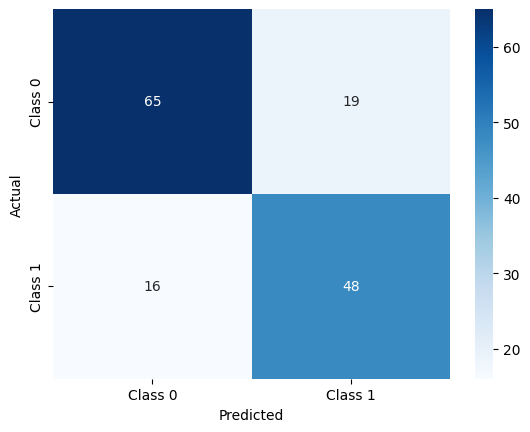

In [163]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Overall, the results are quite promising. The GNN used succesfully employed edge features through GAT's to distinguish Native form Non-Native meeting participants with an accuracy close to 80%. Recognizing that only one layer of convolution was necessary for a fully connected graph, incorporating a dropout layer in training, and finding the optimal sigmoid threshold to split classification all contibuted to the result. Further improvements should include k-fold validation as was done for graph level predicitons. 